In [17]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio

from IPython import display

Input data: <class 'numpy.ndarray'> (60000, 28, 28)


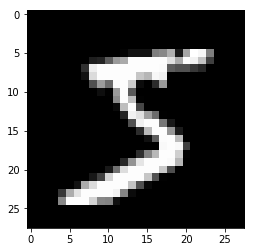

In [18]:
# Load Dataset - Training set from MNIST
(x_train, _) , (x_test, _) = tf.keras.datasets.mnist.load_data()

print('Input data:', type(x_train), x_train.shape)

plt.imshow(x_train[0], cmap='gray', vmin=0, vmax=255)
plt.show()

In [19]:
# Processing of the images
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32')

# ~~ Normalization
x_train = x_train / 255.
x_test = x_test / 255.

# ~~ Binarize
x_train[(x_train >= 0.5)] = 1.
x_train[(x_train < 0.5)] = 0.
x_test[(x_test < 0.5 )] = 0.
x_test[(x_test >= 0.5 )] = 1.

TypeError: Invalid dimensions for image data

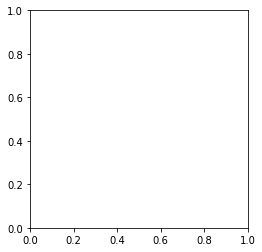

In [20]:
# After binarization
plt.imshow(x_train[0][:,:,None]*255, cmap='gray', vmin=0, vmax=255)
plt.show()

In [21]:
# Batching and shuffling of dataset
TRAIN_BUF = 60000
BATCH_SIZE = 100

TEST_BUF = 10000
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(x_test).shuffle(TEST_BUF).batch(BATCH_SIZE)


In [22]:
# model
class CVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.inference_net = tf.keras.Sequential([
                tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
                tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Flatten(),
                # No activation
                tf.keras.layers.Dense(latent_dim + latent_dim),
            ])

        self.generative_net = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=3,strides=(2, 2),padding="SAME",activation='relu'),
            tf.keras.layers.Conv2DTranspose(filters=32,kernel_size=3,strides=(2, 2),padding="SAME",activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=(1, 1), padding="SAME"),
            ])
        
    # decorator used to transform into graph for gpu compatibility and that kind of stuff
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            tf.random.normal(shape=(100, self.latent_dim)) # why 100??? unit gaussian
        return self.decode(eps, apply_sigmoid=True)
    
    def encode(self, x):
        mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1) # split the output in 2.
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean
    
    def decode(self, z, apply_sigmoid=False):
        """
        From latent variables z will return probabilities of p(x|z) i.e black or white for every pixel
        """
        logits = self.generative_net(z)
        if apply_sigmoid:
            return tf.sigmoid(logits)
        return logits

In [29]:
# Loss and optimizer
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)

@tf.function
def compute_loss(model, x):
    print(x.shape)
    mean, logvar = model.encode(x)
    print(mean.shape)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    print(x_logit.shape)

    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    print(cross_ent.shape)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def compute_apply_gradients(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [30]:
epochs = 10
latent_dim = 50
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [31]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model.sample(test_input)
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

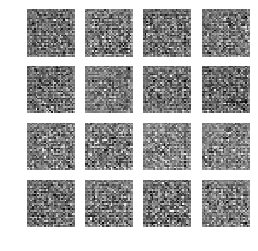

In [32]:
generate_and_save_images(model, 0, random_vector_for_generation)

In [33]:
for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_dataset:
        compute_apply_gradients(model, train_x, optimizer)
    end_time = time.time()

    if epoch % 1 == 0:
        loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        loss(compute_loss(model, test_x))
    elbo = -loss.result()
    display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, '
          'time elapse for current epoch {}'.format(epoch,
                                                    elbo,
                                                    end_time - start_time))
    generate_and_save_images(
        model, epoch, random_vector_for_generation)

(100, 28, 28, 1)
(100, 50)
(100, 28, 28, 1)
(100, 28, 28, 1)


KeyboardInterrupt: 

In [16]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info >= (6,2,0,''):
  display.Image(filename=anim_file)